In [ ]:
#version 2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dropout, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your class names
classes = ['Abnormal heartbeat',
           'History of MI',
           'MI Patients',
           'Normal']

# Initialize ImageDataGenerator for training and validation data
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load and augment data from the directory
train_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(224, 224),  # VGG input size
    batch_size=32,
    classes=classes,
    class_mode="categorical",
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    "/content/drive/MyDrive/preprocessed_ECG_images",
    target_size=(224, 224),
    batch_size=32,
    classes=classes,
    class_mode="categorical",
    subset='validation'
)

# Load VGG16 with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the last few layers of the base model
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create a Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add custom layers on top
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Define callbacks
checkpoint_path = "/content/drive/MyDrive/Model/best_vgg16_model(2).h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.
58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 7, 7, 256)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 256)         0         
 D)                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 22s 812ms/step - loss: 1.2669 - accuracy: 0.4940 - val_loss: 1.2046 - val_accuracy: 0.3770 - lr: 1.0000e-04
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7289
Epoch 2: val_accuracy did not improve from 0.37705
24/24 [==============================] - 21s 869ms/step - loss: 0.6619 - accuracy: 0.7289 - val_loss: 1.9531 - val_accuracy: 0.2732 - lr: 1.0000e-04
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.8027
Epoch 3: val_accuracy improved from 0.37705 to 0.50273, saving model to /content/drive/MyDrive/Model/best_vgg16_model(2).h5
24/24 [==============================] - 22s 932ms/step - loss: 0.5330 - accuracy: 0.8027 - val_loss: 1.2366 - val_accuracy: 0.5027 - lr: 1.0000e-04
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 0.4254 - accuracy: 0.8376
Epoch 4: val_accuracy improved from 0.50273 to 0.64481, saving model to /content/drive/MyDrive/M

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load models

vgg_model = load_model('/content/drive/MyDrive/Model/best_vgg16_model(2).h5')
fused_model = load_model('/content/drive/MyDrive/Model/best_vgg16_model(2).h5')
# Normalization only for evaluation
datagen = ImageDataGenerator(rescale=1./255)

vgg_test_generator = datagen.flow_from_directory(
    directory="/content/drive/MyDrive/preprocessed_ECG_images/",  # Update with your path
    target_size=(224, 224),  # CNN model expects (64, 64)
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 928 images belonging to 4 classes.


29/29 [==============================] - 15s 526ms/step


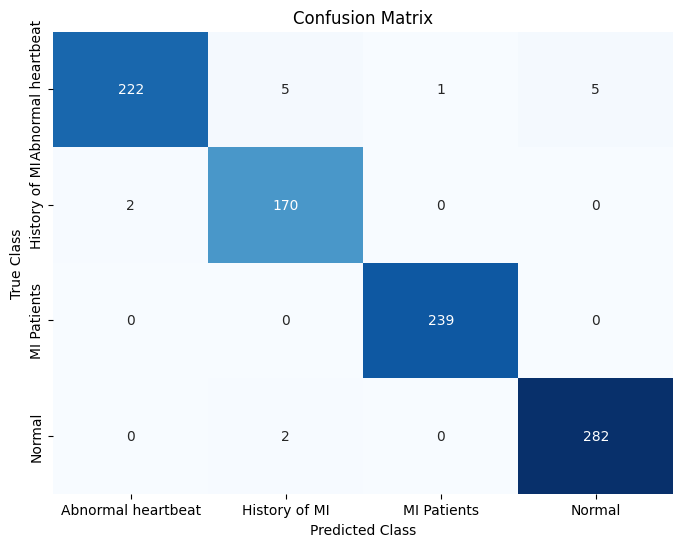

Classification Report:
                    precision    recall  f1-score   support

Abnormal heartbeat       0.99      0.95      0.97       233
     History of MI       0.96      0.99      0.97       172
       MI Patients       1.00      1.00      1.00       239
            Normal       0.98      0.99      0.99       284

          accuracy                           0.98       928
         macro avg       0.98      0.98      0.98       928
      weighted avg       0.98      0.98      0.98       928

Sensitivities: [0.9527896995708155, 0.9883720930232558, 1.0, 0.9929577464788732]
Specificities: [0.9971223021582734, 0.9907407407407407, 0.9985486211901307, 0.9922360248447205]


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, test_generator, steps):
    y_pred_prob = model.predict(test_generator, steps=steps)
    y_pred = np.argmax(y_pred_prob, axis=1)  # Convert predicted probabilities to class labels
    y_true = test_generator.classes

    # Calculate classification report
    report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=list(test_generator.class_indices.keys()), yticklabels=list(test_generator.class_indices.keys()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()


    # Calculate sensitivity and specificity for each class
    sensitivities = []
    specificities = []
    for i in range(len(cm)):
        tp = cm[i, i]  # True positive for class i
        fn = sum(cm[i, :]) - tp  # False negative for class i
        tn = sum(np.delete(np.delete(cm, i, 0), i, 1).ravel())  # True negative for class i
        fp = sum(cm[:, i]) - tp  # False positive for class i

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivities.append(sensitivity)
        specificities.append(specificity)

    return report, sensitivities, specificities

# Evaluate the model and plot the confusion matrix
vgg_steps = vgg_test_generator.samples // vgg_test_generator.batch_size
vgg_report, vgg_sensitivities, vgg_specificities = evaluate_model(vgg_model, vgg_test_generator, vgg_steps)

print(f"Classification Report:\n{vgg_report}")
print(f"Sensitivities: {vgg_sensitivities}")
print(f"Specificities: {vgg_specificities}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
